### 모듈, 패키지 로딩

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [2]:
import matplotlib
import matplotlib.pyplot as plt  # 파이플롯 사용
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')  # 한글코드를 더 선명하게 해주는 조치, 레티나 설정
matplotlib.rc('font', family='AppleGothic') # 폰트 설정
matplotlib.rc('axes', unicode_minus=False) # 마이너스 폰트가 깨지는 경우가 있으므로 조치


### 학습 테스트 데이터 로딩

- 당사자종별을 1당/2당으로 표기한 데이터가 있고 (2012_2014, 2016,2017) 가해자/피해자로 표기한 데이터가 있다 (2015, 2018)
- 피쳐 데이터 : 발생시(hour), 도로형태, 발생지시군구, 사고유형_중분류, 가해자_당사자종별(1당), 피해자_당사자종별(2당)

In [3]:
car_acc_2012_2014 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2012_2014.csv', encoding='euc-kr', engine='python')
car_acc_2012_2014.shape


(14624, 27)

In [4]:
car_acc_2015 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2015.csv', encoding='euc-kr', engine='python')
car_acc_2015.shape

(4447, 26)

In [5]:
car_acc_2016 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2016.csv', encoding='euc-kr', engine='python')
car_acc_2016.shape

(4119, 27)

In [6]:
car_acc_2017 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2017.csv', encoding='euc-kr', engine='python')
car_acc_2017.shape

(4065, 27)

In [7]:
car_acc_2018 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2018.csv', encoding='euc-kr', engine='python')
car_acc_2018.shape

(3657, 26)

In [8]:
#당사자종별을 1당/2당으로 표기한 데이터가 있고 (2012_2014, 2016,2017) 가해자/피해자로 표기한 데이터가 있다 (2015, 2018)

car_acc_2012_2014['가해자_당사자종별'] = car_acc_2012_2014['당사자종별_1당']
car_acc_2012_2014['피해자_당사자종별'] = car_acc_2012_2014['당사자종별_2당']

car_acc_2016['가해자_당사자종별'] = car_acc_2016['당사자종별_1당']
car_acc_2016['피해자_당사자종별'] = car_acc_2016['당사자종별_2당']

car_acc_2017['가해자_당사자종별'] = car_acc_2017['당사자종별_1당']
car_acc_2017['피해자_당사자종별'] = car_acc_2017['당사자종별_2당']


### 전처리

- 피쳐데이터로 쓸 것만 남기기 (레이블 데이터인 사망자수도 일단 포함)
- concat
- 발생시hour 변환 작업
- 발생시도 + 발생시군구를 합치기
- 사망자수 1 or 다수로 2분할 (0 - 1명 사망 , 1 - 다수 사망)
- 각 피쳐 null 처리 및 피쳐 엔지니어링


In [9]:
ftr_columns = ['발생년월일시', '발생지시도', '발생지시군구', '사고유형_중분류', '가해자_당사자종별', '피해자_당사자종별', '사망자수']

In [10]:
# 발생년월일시분이라고 저장된 데이터셋은 따로 처리
car_acc_2015['발생년월일시'] = car_acc_2015['발생년월일시분']
car_acc_2018['발생년월일시'] = car_acc_2018['발생년월일시분']

In [11]:
# 필요한 피쳐만 남겨서 새로운 데이터프레임에 저장

car_acc_2012_2014_ftr = car_acc_2012_2014[ftr_columns]
car_acc_2015_ftr = car_acc_2015[ftr_columns]
car_acc_2016_ftr = car_acc_2016[ftr_columns]
car_acc_2017_ftr = car_acc_2017[ftr_columns]
car_acc_2018_ftr = car_acc_2018[ftr_columns]

In [12]:
# concat

car_acc_ftr = pd.concat([car_acc_2012_2014_ftr, 
                         car_acc_2015_ftr, 
                         car_acc_2016_ftr, 
                         car_acc_2017_ftr, 
                         car_acc_2018_ftr], sort = False)
car_acc_ftr.tail()

,발생년월일시,발생지시도,발생지시군구,사고유형_중분류,가해자_당사자종별,피해자_당사자종별,사망자수
3652,2018-05-21 03:55,경기,포천시,공작물충돌,승용차,없음,1
3653,2018-06-08 08:43,경기,포천시,추돌,화물차,농기계,1
3654,2018-01-20 10:15,경기,가평군,공작물충돌,승용차,없음,1
3655,2018-02-03 21:05,경기,가평군,정면충돌,승용차,승용차,1
3656,2018-12-03 10:05,경기,연천군,측면충돌,승용차,승용차,1


In [13]:
# hour 변환 - null값 없음 확인

car_acc_ftr['발생시'] = pd.to_datetime(car_acc_ftr['발생년월일시'])
car_acc_ftr['발생시'] = car_acc_ftr['발생시'].dt.hour

In [14]:
car_acc_ftr['발생지'] = car_acc_ftr['발생지시도'] + '-' + car_acc_ftr['발생지시군구']

In [15]:
car_acc_ftr = car_acc_ftr.drop(['발생지시도', '발생지시군구'], axis = 1)

In [16]:
def 사망자수_이진분류(count):
    if count == 1:
        return 0
    else:
        return 1

#### 가해자 데이터 전처리

- 경형 -> 소형 으로 편입
- 원동기장치자전거 -> 이륜차로 편입
- 사발이, 사륜오토바이 -> 이륜차로 편입
- 승합차 -> 대형으로 편입
- 특수차, 불명, 개인형이동수단, 기타 -> 기타로 편입

In [17]:
# 가해자_당사자종별 데이터 전처리

car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '경형', '가해자_당사자종별'] = '소형'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '원동기장치자전거', '가해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '사발이', '가해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '사륜오토바이(ATV)', '가해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '승합차', '가해자_당사자종별'] = '대형'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '특수차', '가해자_당사자종별'] = '기타'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '불명', '가해자_당사자종별'] = '기타'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '개인형이동수단(PM)', '가해자_당사자종별'] = '기타'



#### 피해자 데이터 전처리

- 00 -> 대물사고 로 구체화
- 없음 -> 대물사고로 구체화
- 경형 -> 소형 으로 편입
- 원동기장치자전거 -> 이륜차로 편입
- 사발이, 사륜오토바이 -> 이륜차로 편입
- 승합차 -> 대형으로 편입
- 불명 -> 보행자로 편입
- 특수차, 개인형이동수단, 기타 -> 기타로 편입

In [18]:
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '00', '피해자_당사자종별'] = '대물사고'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '없음', '피해자_당사자종별'] = '대물사고'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '경형', '피해자_당사자종별'] = '소형'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '승합차', '피해자_당사자종별'] = '대형'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '원동기장치자전거', '피해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '사발이', '피해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '사륜오토바이(ATV)', '피해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '특수차', '피해자_당사자종별'] = '기타'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '불명', '피해자_당사자종별'] = '기타'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '열차', '피해자_당사자종별'] = '기타'


#### 사고유형_중분류 데이터 전처리

- 전도 -> 전도전복 으로 편입
- 전복 -> 전도전복 으로 편입
- 차도, 보도통행중 -> 횡단중 으로 편입
- 직전진행, 경보기무시, 차단기돌파, 철길건널목 -> 기타로 편입


In [19]:
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '전도', '사고유형_중분류'] = '전도전복'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '전복', '사고유형_중분류'] = '전도전복'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '차도통행중', '사고유형_중분류'] = '횡단중'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '보도통행중', '사고유형_중분류'] = '횡단중'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '직전진행', '사고유형_중분류'] = '기타'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '경보기무시', '사고유형_중분류'] = '기타'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '차단기돌파', '사고유형_중분류'] = '기타'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '철길건널목', '사고유형_중분류'] = '기타'


In [20]:
car_acc_ftr['사망자수_타겟값'] = car_acc_ftr['사망자수'].apply(사망자수_이진분류)

In [21]:
car_acc_ftr = car_acc_ftr.drop(['사망자수', '발생년월일시'], axis =1)

In [34]:
car_acc_ftr['사망자수_타겟값'].value_counts()

0    29916
1      996
Name: 사망자수_타겟값, dtype: int64

## 머신러닝 학습 진행 (랜덤포레스트)

### 원핫인코딩

In [ ]:
X_df = car_acc_ftr.iloc[:,:-1]
y_df = car_acc_ftr.iloc[:,-1]

In [28]:
X_features_ohe = pd.get_dummies(X_df, columns=X_df.columns)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_df, test_size=0.2, random_state=11)

In [54]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(rf_accuracy))

print('RandomForestClassifier 기본 하이퍼 파라미터:\n', rf_clf.get_params())

랜덤 포레스트 정확도: 0.9652
RandomForestClassifier 기본 하이퍼 파라미터:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [66]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [67]:
get_clf_eval(y_test, rf_pred)

오차 행렬
[[5966   10]
 [ 205    2]]
정확도: 0.9652, 정밀도: 0.1667, 재현율: 0.0097


In [68]:
f1 = f1_score(y_test, rf_pred)
print(f1)

0.0182648401826484


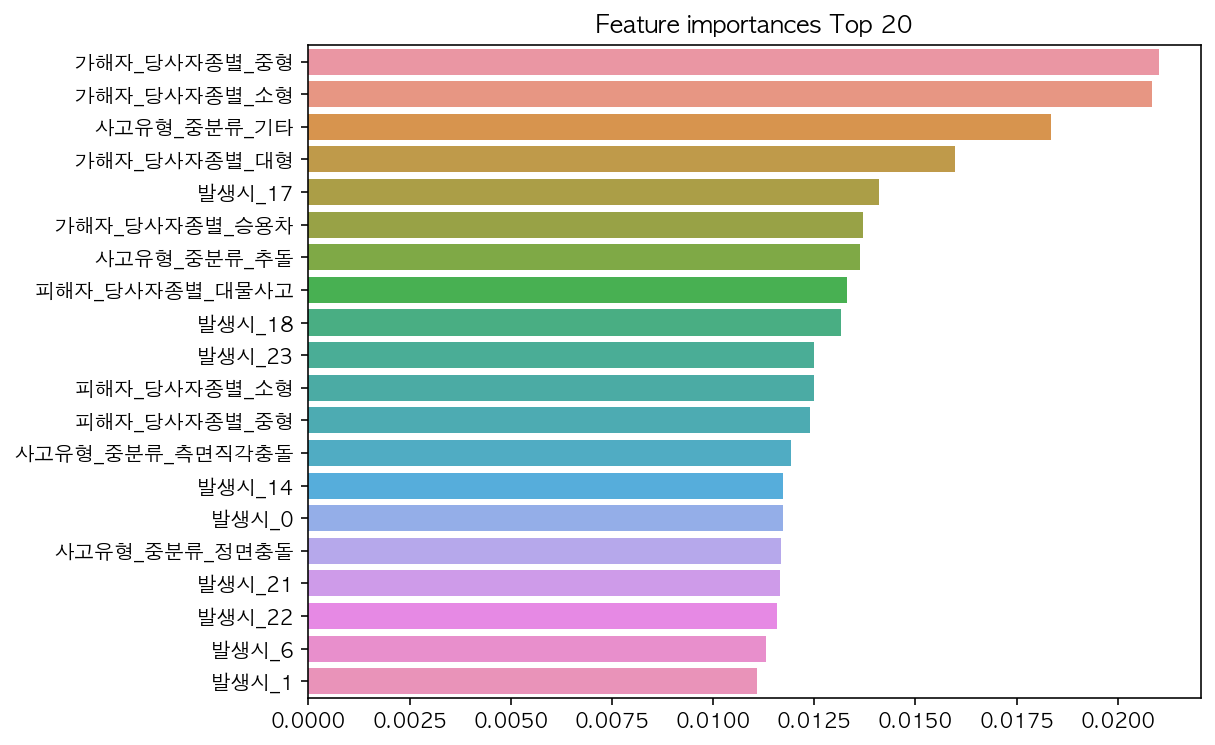

In [33]:
ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [48]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test , lr_preds)))

accuracy: 0.967
roc_auc: 0.500


In [56]:
get_clf_eval(y_test, lr_preds)

오차 행렬
[[5976    0]
 [ 207    0]]
정확도: 0.9665, 정밀도: 0.0000, 재현율: 0.0000


/Users/taewoongkong/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
pred_proba = lr_clf.predict_proba(X_test)

In [73]:
print(pred_proba)

[[0.95312698 0.04687302]
 [0.99709368 0.00290632]
 [0.96561677 0.03438323]
 ...
 [0.9076655  0.0923345 ]
 [0.99150427 0.00849573]
 [0.89708825 0.10291175]]
